In [422]:
from environment import Environment, FixedBudgetEnvironment
import matplotlib.pyplot as plt
import math
import numpy as np
from game import SumUnanimityGames, GlobalFeatureImportance, LocalFeatureImportance, UnsupervisedFeatureImportance, TestGame
from plot import plot_order
from util import *

In [423]:
from algorithms.CMCS import CMCS, CMCS_Dependent, CMCS_Independent, CMCS_Length
from algorithms.GapE import GapE
from algorithms.SAR import SAR
from algorithms.ApproShapley import ApproShapley
from algorithms.BUS import BUS
from algorithms.HybridApproBUS import SmartHybridApproBUS
from algorithms.SVARM import SVARM, StratSVARM
from algorithms.ShapleySort import ShapleySort
from algorithms.KernelSHAP import KernelSHAP
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [424]:
n=14

In [425]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

In [426]:
filepath_global = "datasets/Global feature importance/Bike sharing regression random forest.csv"
filepath_unsupervised = "datasets/Unsupervised Feature Importance/vf_BigFive.csv"
directory_local = "datasets/adult_classification"
game = GlobalFeatureImportance(filepath=filepath_global, num_players=n, use_cached=True)
# game = LocalFeatureImportance(directory=directory_local, num_players=n)
# game = UnsupervisedFeatureImportance(filepath=filepath_unsupervised, num_players=n)
# game = SumUnanimityGames()
# game = TestGame(n)
game_name = game.name
game_type = game.__class__.__name__

In [427]:
# values, games = game.reindex_all()
# num_games = len(games)
# shapley_values, _ = game.get_all_phi(values)
# shapley_values.shape

(60, 14)

In [428]:
values = game.values[np.newaxis, :]
num_games = 1
shapley_values = game.phi[np.newaxis, :]

In [429]:
var = calc_variance(n, values, shapley_values)
cov = calc_covariance(n, values, shapley_values)
var, cov

(array([[0.00, 0.03, -0.00, 0.00, 0.00, 0.00, 0.00, 0.02, 0.00, 0.01,
         -0.00, 0.00, 0.00, 0.00],
        [0.00, 0.00, 0.00, 0.00, 0.00, -0.00, -0.00, 0.00, 0.00, 0.00,
         -0.00, -0.00, 0.00, -0.00],
        [0.00, 0.00, 0.00, 0.00, 0.00, -0.00, 0.00, 0.00, -0.00, 0.00,
         -0.00, -0.00, 0.00, 0.00],
        [0.00, 0.00, 0.00, 0.00, -0.00, 0.00, -0.00, -0.00, 0.00, -0.00,
         -0.00, -0.00, 0.00, 0.00],
        [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, -0.00, 0.00, 0.00, -0.00,
         -0.00, 0.00, 0.00, 0.00],
        [0.00, 0.00, -0.00, 0.00, 0.00, -0.00, -0.00, 0.00, 0.00, 0.00,
         -0.00, -0.00, 0.00, 0.00],
        [0.01, 0.01, 0.00, 0.00, 0.00, -0.00, -0.00, 0.01, 0.01, 0.00,
         -0.00, -0.00, 0.00, 0.00],
        [0.00, 0.00, 0.00, 0.00, 0.00, -0.00, 0.00, 0.00, 0.00, 0.00,
         -0.00, -0.00, 0.00, -0.00],
        [0.00, 0.02, 0.08, 0.00, 0.00, 0.00, -0.00, 0.03, 0.00, 0.03,
         -0.00, -0.00, 0.00, 0.00],
        [0.00, 0.02, 0.04, 0.00, 0.00

In [430]:
var_diff_independent = np.zeros_like(cov)
var_diff_independent = var[:, :, np.newaxis] + var[:, np.newaxis, :]
var_diff_dependent = var_diff_independent - 2 * cov
var_diff_dependent, var_diff_independent

(array([[[0.00, 0.03, 0.00, ..., 0.00, 0.00, 0.01],
         [0.03, 0.00, 0.03, ..., 0.03, 0.03, 0.04],
         [0.00, 0.03, 0.00, ..., 0.00, 0.00, 0.00],
         ...,
         [0.00, 0.03, 0.00, ..., 0.00, 0.00, 0.01],
         [0.00, 0.03, 0.00, ..., 0.00, 0.00, 0.00],
         [0.01, 0.04, 0.00, ..., 0.01, 0.00, 0.00]],
 
        [[0.00, 0.00, 0.00, ..., 0.00, 0.00, 0.00],
         [0.00, 0.00, 0.00, ..., 0.00, 0.00, 0.00],
         [0.00, 0.00, 0.00, ..., -0.00, 0.00, -0.00],
         ...,
         [0.00, 0.00, -0.00, ..., 0.00, 0.00, -0.00],
         [0.00, 0.00, 0.00, ..., 0.00, 0.00, 0.00],
         [0.00, 0.00, -0.00, ..., -0.00, 0.00, 0.00]],
 
        [[0.00, 0.00, 0.00, ..., 0.00, 0.00, 0.00],
         [0.00, 0.00, 0.00, ..., 0.00, 0.00, 0.01],
         [0.00, 0.00, 0.00, ..., -0.00, 0.00, 0.00],
         ...,
         [0.00, 0.00, -0.00, ..., 0.00, 0.00, 0.00],
         [0.00, 0.00, 0.00, ..., 0.00, 0.00, 0.00],
         [0.00, 0.01, 0.00, ..., 0.00, 0.00, 0.00]],
 
     

In [431]:
var_diff_dependent.shape

(60, 14, 14)

In [432]:
sorted_indices = np.argsort(-shapley_values, axis=-1)
sorted_indices[0]

array([ 1,  7,  9,  8, 13, 12,  3,  4, 10,  2,  6,  5, 11,  0],
      dtype=int64)

In [433]:
relative_variance = var_diff_dependent / var_diff_independent 
# relative_variance_pairs = relative_variance[:, *np.triu_indices(n, k=1)]
# assert relative_variance_pairs.shape[1] == n*(n-1)/2
relative_variance.shape, relative_variance[0]

C:\Users\Tim\AppData\Local\Temp\ipykernel_17444\1561443484.py:1: RuntimeWarning: invalid value encountered in divide
  relative_variance = var_diff_dependent / var_diff_independent


((60, 14, 14),
 array([[0.00, 1.03, 1.00, 1.03, 1.15, 0.95, 1.00, 1.20, 1.33, 1.28, 1.00,
         0.84, 1.38, 1.25],
        [1.03, 0.00, 1.00, 0.94, 1.00, 1.00, 1.00, 0.87, 0.97, 0.86, 1.00,
         0.96, 0.99, 1.05],
        [1.00, 1.00, -0.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00,
         0.92, 1.00, 1.00, 1.00],
        [1.03, 0.94, 1.00, 0.00, 0.96, 1.22, 1.02, 1.00, 1.04, 1.00, 1.00,
         0.89, 1.09, 1.06],
        [1.15, 1.00, 1.00, 0.96, 0.00, 0.58, 0.94, 1.01, 1.04, 1.00, 1.00,
         0.70, 0.98, 0.94],
        [0.95, 1.00, 1.00, 1.22, 0.58, 0.00, 0.93, 1.05, 1.15, 1.08, 1.00,
         0.56, 1.13, 1.09],
        [1.00, 1.00, 1.00, 1.02, 0.94, 0.93, 0.00, 1.00, 1.01, 1.00, 1.00,
         1.00, 1.05, 1.00],
        [1.20, 0.87, 1.00, 1.00, 1.01, 1.05, 1.00, 0.00, 0.43, 0.40, 1.00,
         1.17, 0.88, 0.71],
        [1.33, 0.97, 1.00, 1.04, 1.04, 1.15, 1.01, 0.43, 0.00, 0.40, 1.00,
         1.47, 0.61, 0.48],
        [1.28, 0.86, 1.00, 1.00, 1.00, 1.08, 1.00, 0.40, 

In [434]:
batch_indices = np.arange(num_games)[:, None]
relative_variance_pairs = relative_variance[
    batch_indices,
    sorted_indices[:, :-1],
    sorted_indices[:, 1:]
]

In [435]:
relative_variance_pairs[0]

array([0.87, 0.40, 0.40, 0.48, 0.79, 1.09, 0.96, 1.00, 0.92, 1.00, 0.93,
       0.56, 0.84])

In [436]:
relative_variance_pairs.shape

(60, 13)

In [437]:
plt.style.use(plt.style.library['ggplot'])
plt.rcParams.update({'font.size': 12})
plt.rcParams['legend.frameon'] = False
plt.rcParams['lines.markersize'] = 10

In [438]:
# histograms = []
# sub_x = 5
# sub_y = int(np.ceil(num_games/sub_x))
# fig, ax = plt.subplots(sub_y, sub_x, figsize=(6*sub_x,5*sub_y), dpi=100)
# for index, var in enumerate(relative_variance_pairs):
#     counts, edges = np.histogram(var, bins=20, range=(0,2))
#     x = edges[:-1]
#     widths = edges[1:] - edges[:-1]
#     area = counts * widths
#     density = area / np.sum(area)
#     i, j = index // sub_x, index % sub_x
#     ax[i,j].set_ylim(0, 1)
#     ax[i, j].bar(x, density, widths)
# fig.show()
# plt.savefig(f"results/difference_variance_evaluation/{game_type}({game_name})_all_games_all_pairs", bbox_inches='tight')

In [439]:
all_games_relative_variance_pairs = relative_variance_pairs.reshape(-1)
all_games_relative_variance_pairs.shape

(780,)

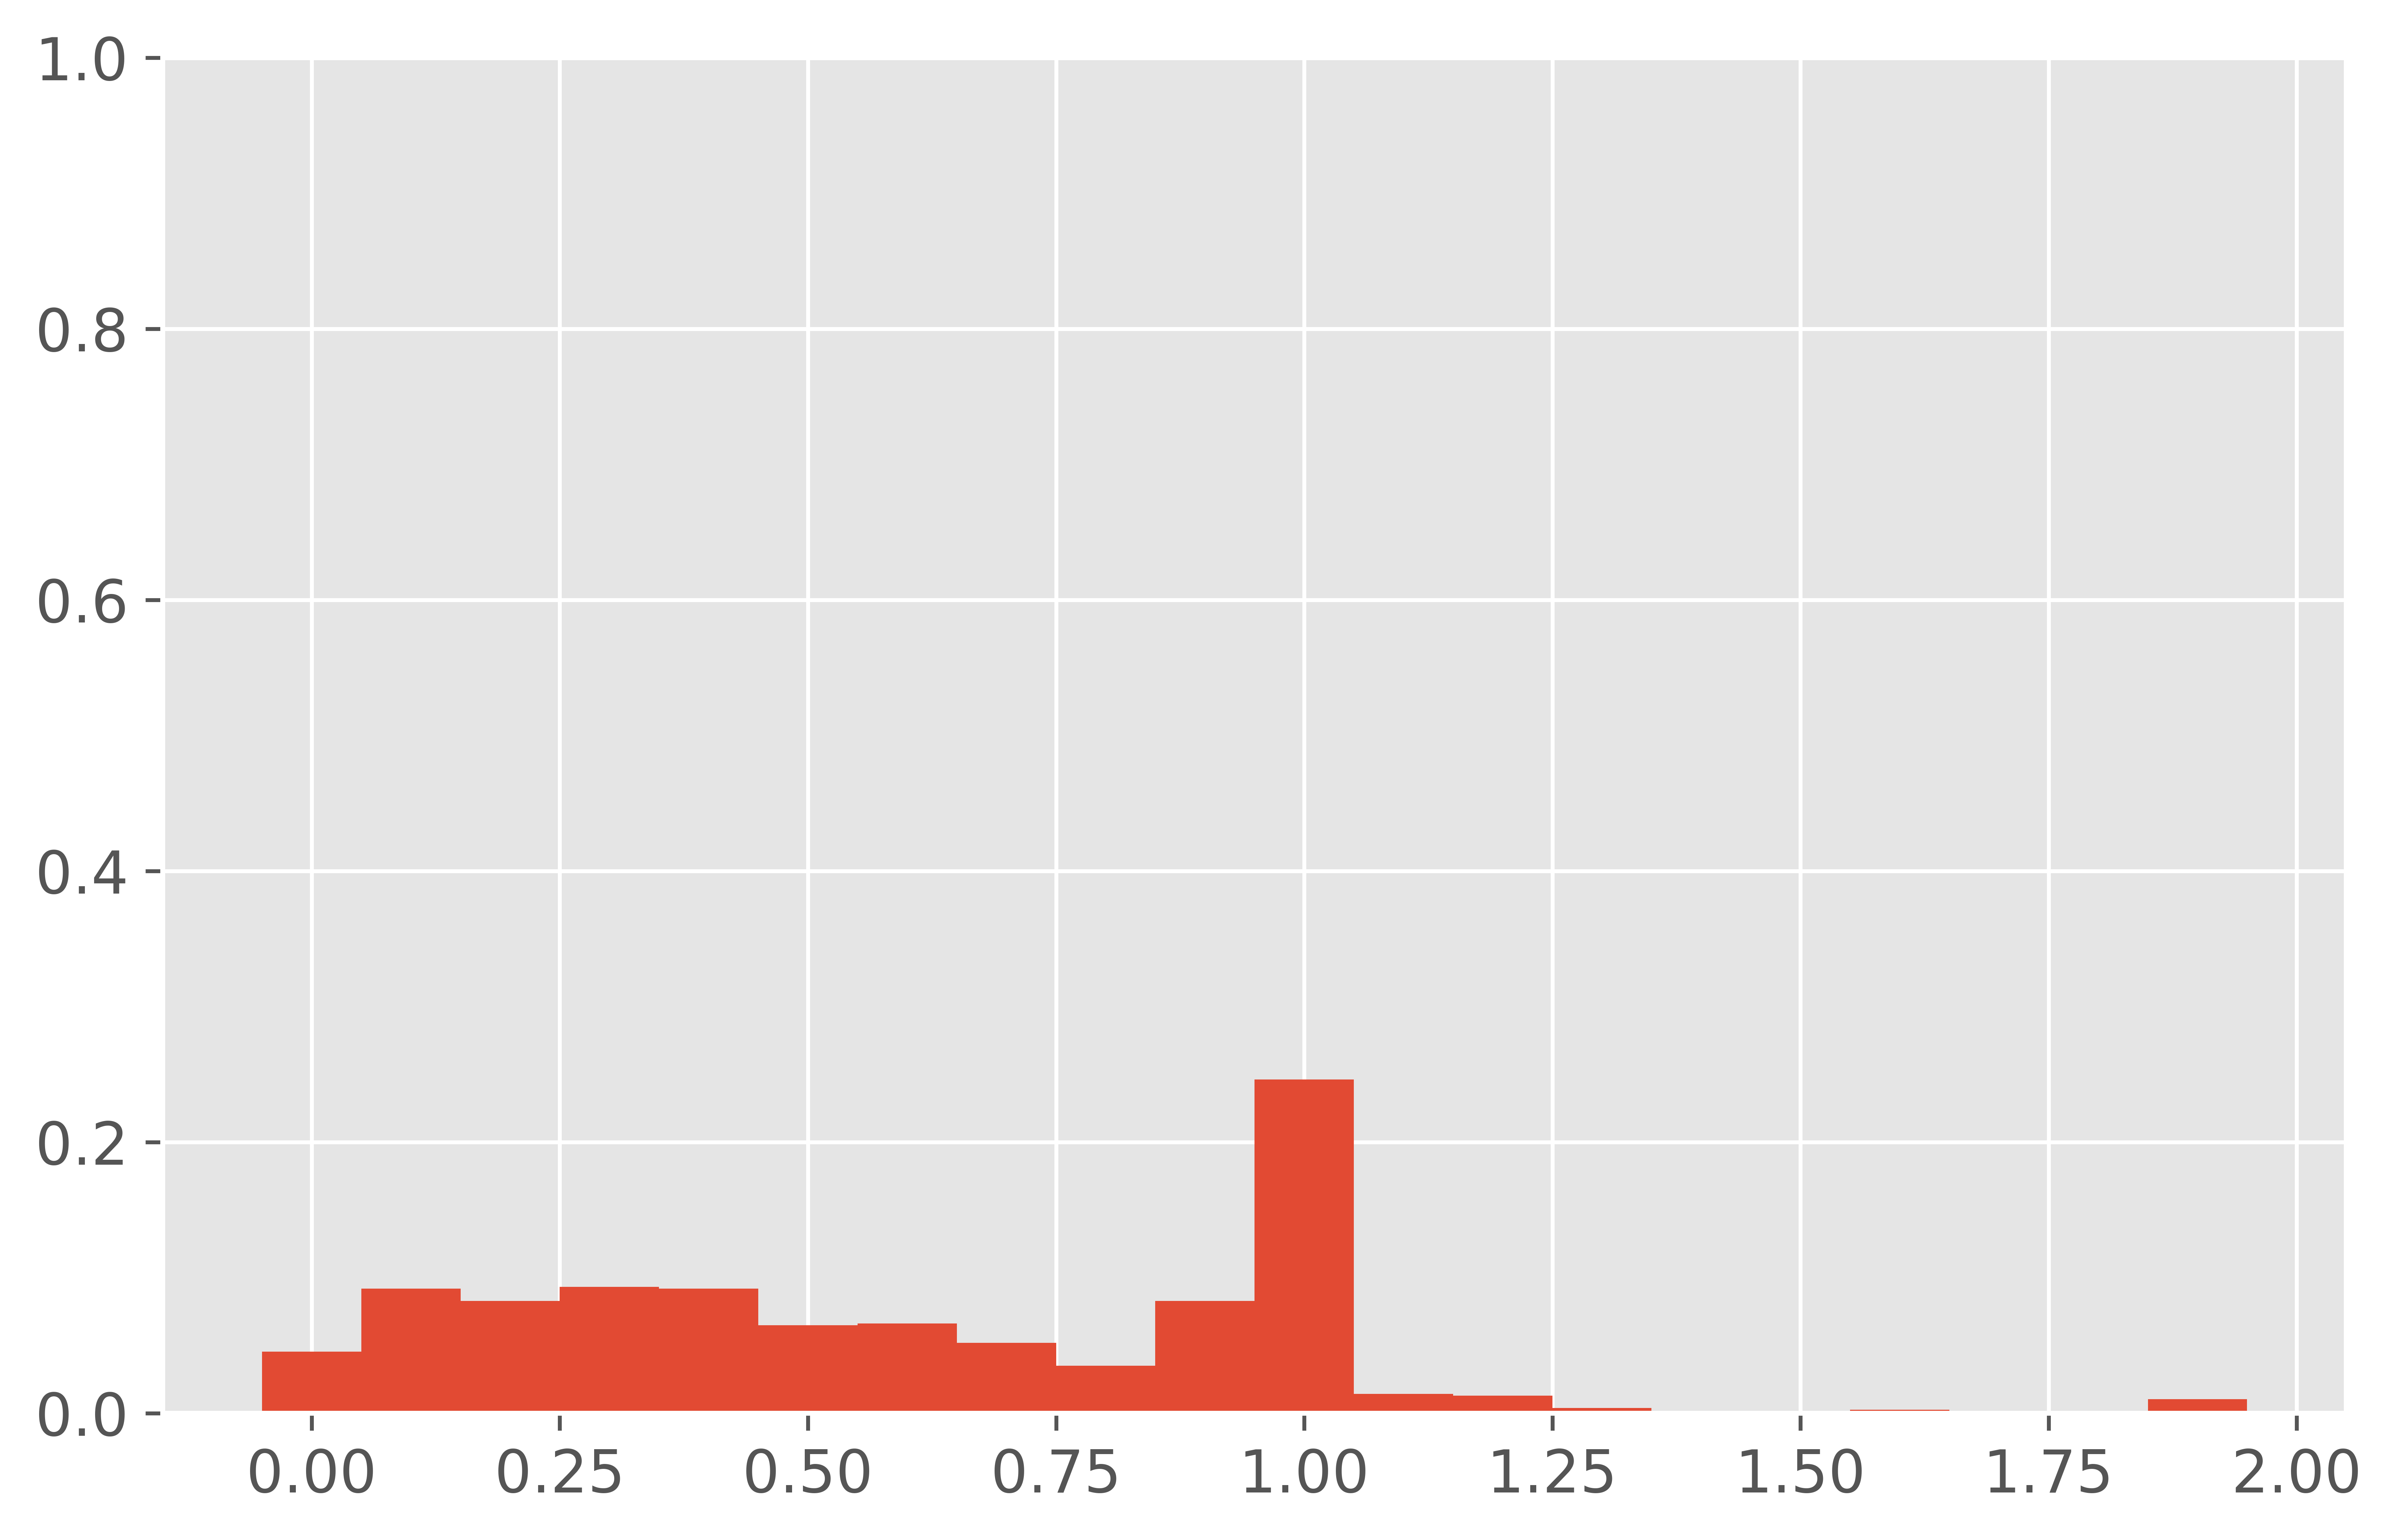

In [440]:
fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=1000)
counts, edges = np.histogram(all_games_relative_variance_pairs, bins=20, range=(0,2))
x = edges[:-1]
widths = edges[1:] - edges[:-1]
area = counts * widths
density = area / np.sum(area)
ax.set_ylim(0, 1)
ax.bar(x, density, widths)
plt.savefig(f"results/difference_variance_evaluation/{game_type}({game.name})_aggregate_all_pairs", bbox_inches='tight')

In [441]:
mean_relative_variance_pais = np.mean(relative_variance_pairs, axis=1)

In [442]:
# fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=1000)
# counts, edges = np.histogram(mean_relative_variance_pais, bins=20, range=(0,2))
# x = edges[:-1]
# widths = edges[1:] - edges[:-1]
# area = counts * widths
# density = area / np.sum(area)
# ax.set_ylim(0, 1)
# ax.bar(x, density, widths)
# plt.savefig(f"results/difference_variance_evaluation/{game_type}({game.name})_mean_all_pairs", bbox_inches='tight')

In [443]:
k=1

In [444]:
sorted = np.argsort(-shapley_values, axis=1)
topk, rest = sorted[:, :k], sorted[:, k:]
topk.shape, rest.shape


((60, 1), (60, 13))

In [445]:
relative_variance[0]

array([[0.00, 1.03, 1.00, 1.03, 1.15, 0.95, 1.00, 1.20, 1.33, 1.28, 1.00,
        0.84, 1.38, 1.25],
       [1.03, 0.00, 1.00, 0.94, 1.00, 1.00, 1.00, 0.87, 0.97, 0.86, 1.00,
        0.96, 0.99, 1.05],
       [1.00, 1.00, -0.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00,
        0.92, 1.00, 1.00, 1.00],
       [1.03, 0.94, 1.00, 0.00, 0.96, 1.22, 1.02, 1.00, 1.04, 1.00, 1.00,
        0.89, 1.09, 1.06],
       [1.15, 1.00, 1.00, 0.96, 0.00, 0.58, 0.94, 1.01, 1.04, 1.00, 1.00,
        0.70, 0.98, 0.94],
       [0.95, 1.00, 1.00, 1.22, 0.58, 0.00, 0.93, 1.05, 1.15, 1.08, 1.00,
        0.56, 1.13, 1.09],
       [1.00, 1.00, 1.00, 1.02, 0.94, 0.93, 0.00, 1.00, 1.01, 1.00, 1.00,
        1.00, 1.05, 1.00],
       [1.20, 0.87, 1.00, 1.00, 1.01, 1.05, 1.00, 0.00, 0.43, 0.40, 1.00,
        1.17, 0.88, 0.71],
       [1.33, 0.97, 1.00, 1.04, 1.04, 1.15, 1.01, 0.43, 0.00, 0.40, 1.00,
        1.47, 0.61, 0.48],
       [1.28, 0.86, 1.00, 1.00, 1.00, 1.08, 1.00, 0.40, 0.40, 0.00, 1.00,
        1.20, 0.

In [446]:
topk[0], rest[0]

(array([1], dtype=int64),
 array([ 7,  9,  8, 13, 12,  3,  4, 10,  2,  6,  5, 11,  0], dtype=int64))

In [447]:
indices_topk = np.zeros((num_games, k, n-k), dtype=np.int32)
indices_rest = np.zeros((num_games, k, n-k), dtype=np.int32)
print(indices_topk.shape, indices_rest.shape)
for game in range(num_games):
    indices_topk[game], indices_rest[game] = np.meshgrid(topk[game], rest[game], indexing='ij')

(60, 1, 13) (60, 1, 13)


In [448]:
np.mgrid[:num_games, :k*(n-k)][0].shape

(60, 13)

In [449]:
relevant_pairs = relative_variance[np.mgrid[:num_games, :k*(n-k)][0], indices_topk.reshape(num_games, -1), indices_rest.reshape(num_games, -1)]
relevant_pairs

array([[0.87, 0.86, 0.97, 1.05, 0.99, 0.94, 1.00, 1.00, 1.00, 1.00, 1.00,
        0.96, 1.03],
       [1.22, 1.04, 1.06, 1.01, 1.04, 1.06, 1.00, 1.00, 1.00, 1.00, 1.00,
        1.00, 1.02],
       [0.52, 0.43, 0.58, 0.98, 1.00, 1.00, 1.00, 1.00, 1.00, 0.99, 1.04,
        1.55, 1.48],
       [0.42, 0.65, 0.54, 0.59, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00,
        1.00, 1.02],
       [0.58, 0.56, 0.77, 0.84, 0.87, 0.74, 1.00, 1.00, 1.00, 1.00, 1.13,
        1.57, 1.44],
       [0.72, 0.76, 0.58, 1.00, 1.00, 1.00, 1.00, 1.00, 1.04, 1.27, 1.14,
        1.16, 1.20],
       [0.37, 0.42, 0.49, 0.64, 0.83, 0.85, 1.00, 1.00, 1.00, 1.00, 1.00,
        1.36, 1.64],
       [0.61, 0.72, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.15, 1.29,
        1.31, 1.01],
       [0.51, 0.55, 0.55, 0.90, 0.92, 0.97, 1.04, 1.00, 1.00, 1.00, 1.00,
        1.04, 1.04],
       [0.63, 0.64, 0.63, 0.73, 0.85, 0.88, 0.89, 0.98, 1.00, 1.00, 1.00,
        1.01, 1.10],
       [0.32, 0.36, 0.45, 0.66, 0.74, 0.82, 0.88, 

In [450]:
# histograms = []
# sub_x = 5
# sub_y = int(np.ceil(num_games/sub_x))
# fig, ax = plt.subplots(sub_y, sub_x, figsize=(6*sub_x,5*sub_y), dpi=100)
# for index, var in enumerate(relevant_pairs):
#     counts, edges = np.histogram(var, bins=20, range=(0,2))
#     x = edges[:-1]
#     widths = edges[1:] - edges[:-1]
#     area = counts * widths
#     density = area / np.sum(area)
#     i, j = index // sub_x, index % sub_x
#     ax[i,j].set_ylim(0, 1)
#     ax[i, j].bar(x, density, widths)
# fig.show()
# plt.savefig(f"results/difference_variance_evaluation/{game_type}({game_name})_all_games_top{k}_rest", bbox_inches='tight')

In [451]:
mean_relevant_pairs = np.mean(relevant_pairs, axis=1)

In [452]:
# fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=1000)
# counts, edges = np.histogram(mean_relevant_pairs, bins=20, range=(0,2))
# x = edges[:-1]
# widths = edges[1:] - edges[:-1]
# area = counts * widths
# density = area / np.sum(area)
# ax.set_ylim(0, 1)
# ax.bar(x, density, widths)
# plt.savefig(f"results/difference_variance_evaluation/{game_type}({game_name})_mean_top{k}_rest", bbox_inches='tight')

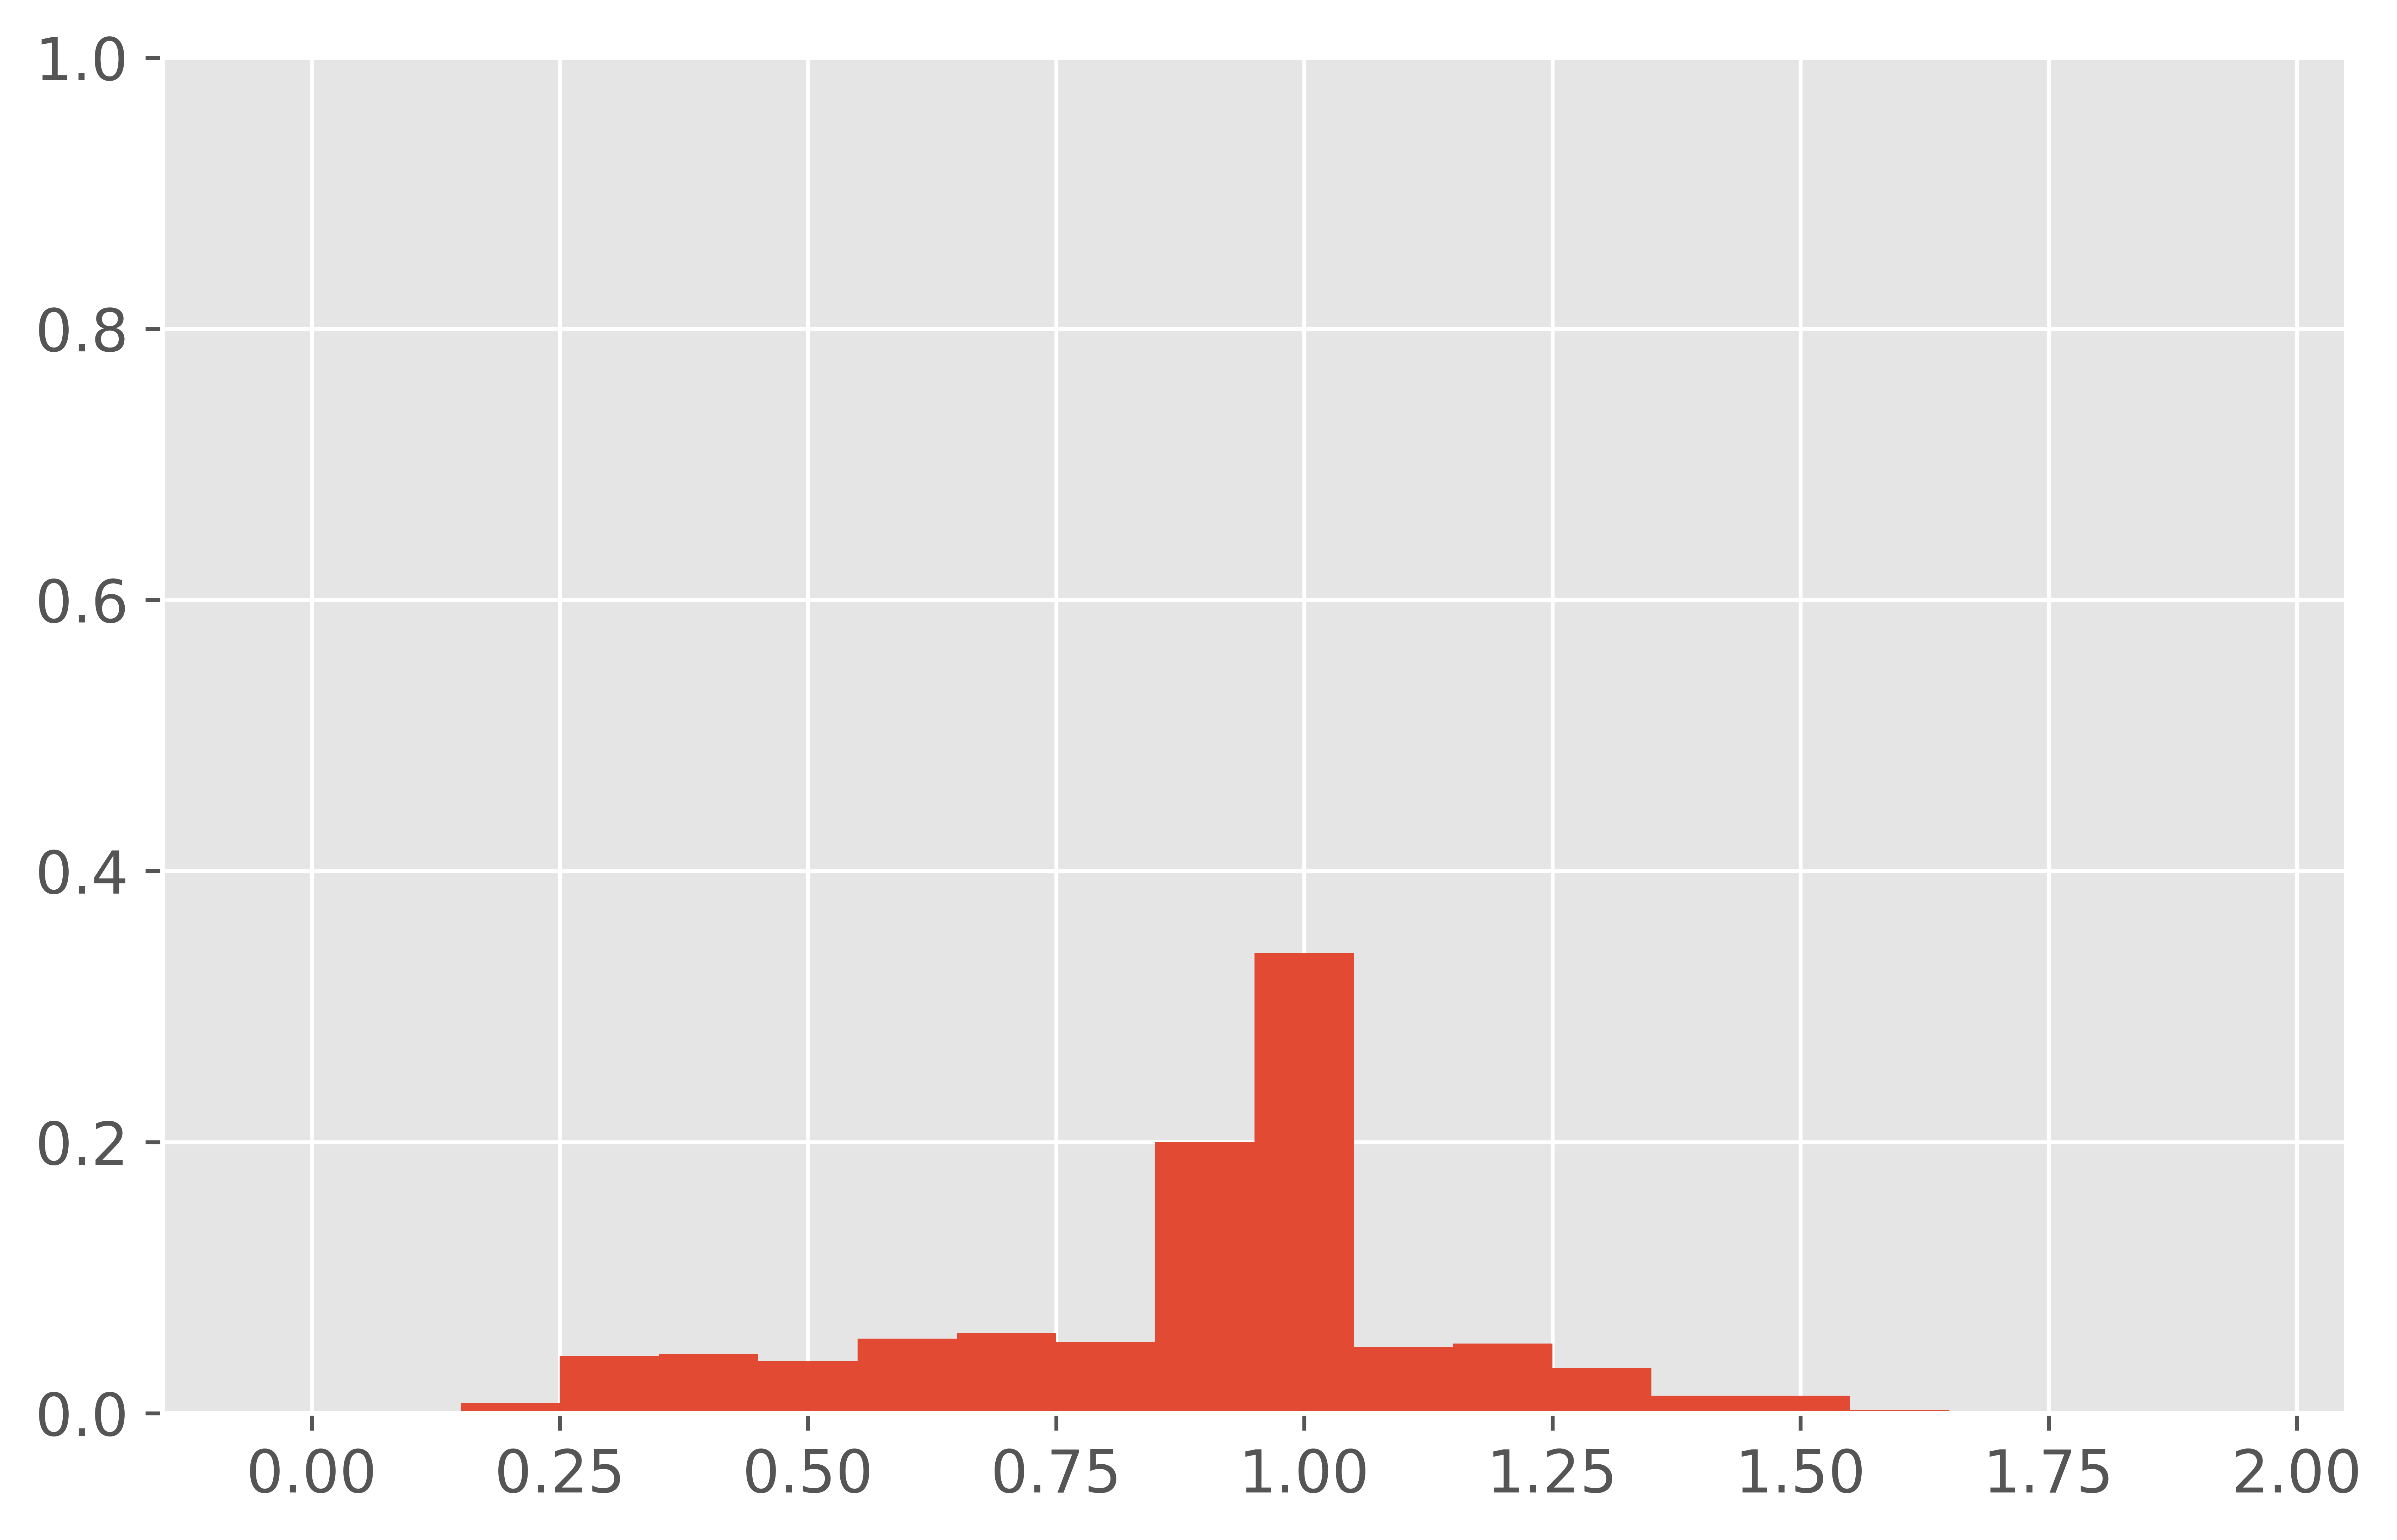

In [453]:
fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=1000)
counts, edges = np.histogram(relevant_pairs.reshape(-1), bins=20, range=(0,2))
x = edges[:-1]
widths = edges[1:] - edges[:-1]
area = counts * widths
density = area / np.sum(area)
ax.set_ylim(0, 1)
ax.bar(x, density, widths)
plt.savefig(f"results/difference_variance_evaluation/{game_type}({game_name})_aggregate_top{k}_rest", bbox_inches='tight')